### Menu
- <a href=#Individual> 1. Define Individual Transform </a>
- <a href=#Pipeline> 2. Chaining Transform into Pipeline </a>
- <a href=#TfmdLists> 3. Pipeline to TfmdLists </a>
- <a href=#DataLoaders> 4. TfmdLists to DataLoaders </a>
- <a href=#Datablock> 5. Packing as Datablock </a>

### Notes
1. Don't overwrite self.\__repr__ of your subclass Transform / ItemTransform
2. Why TfmdLists.items is a list, NOT L?
3. Even in batch, semgmentation mask only has 3 dim (e.g. (BS, H, W))

In [3]:
from fastai2.vision.all import *
import pandas as pd

%load_ext autoreload
%autoreload 2

In [4]:
PATH = Path('/userhome/34/h3509807/ship-data')
csv_path = PATH.ls()[1]
df = pd.read_csv(csv_path)
df = df.set_index('ImageId')

In [5]:
items = L(df.index.tolist()).unique()
items

(#192556) ['00003e153.jpg','0001124c7.jpg','000155de5.jpg','000194a2d.jpg','0001b1832.jpg','00021ddc3.jpg','0002756f7.jpg','0002d0f32.jpg','000303d4d.jpg','00031f145.jpg'...]

<a id='Individual'></a>
#### 1. Individual Transform

In [10]:
def rle_decode(mask_rle, shape = (768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype = np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype = int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

class RawExtract(Transform):
    def __init__(self, csv_path):
        if isinstance(csv_path, str):
            csv_path = Path(csv_path)
        self.root = csv_path.parent
        self.csv_path = csv_path
        df = pd.read_csv(self.csv_path)
        self.df = df.set_index('ImageId')
        
    def encodes(self, img_id):
        fn = self.root / 'train_v2' / img_id
        rle = self.df.loc[img_id, 'EncodedPixels']
        return (fn, rle)

class Rasterize(Transform):
    mask_sz = (768, 768)
    
    def encodes(self, x: Path):
        img = PILImage.create(x)
        return img
    
    def encodes(self, x: float):
        np_arr = np.zeros(shape = self.mask_sz, dtype = np.uint8)
        return PILMask.create(np_arr)
    
    def encodes(self, x: str):
        np_arr = rle_decode(x)
        return PILMask.create(np_arr)
        
    def encodes(self, x: pd.Series):
        rles = x.values.tolist()
        np_arr = np.zeros(shape = self.mask_sz, dtype = np.uint8)
        for rle in rles:
            tmp = rle_decode(rle)
            np_arr += tmp
        return PILMask.create(np_arr)
    
class LabeledImage(Tuple):
    def show(self, ctx = None, **kwargs):
        img, mask = self
        img, mask = TensorImage(img), TensorMask(mask)
        ctx1 = img.show(ctx = ctx)
        return mask.show(ctx = ctx1, **kwargs)
        #return show_image(ctx2, ctx = ctx, **kwargs)
        #return show_image(mask, ctx = ctx, alpha = 0.5)
    
class Semantize(ItemTransform):
    def encodes(self, x):
        return LabeledImage(*x)

In [11]:
raw_tfms = RawExtract(csv_path)
raw_tfms.setup()
rasterize = Rasterize()
semantize = Semantize()

In [12]:
img_id = items[3]

out = semantize(rasterize(raw_tfms(img_id)))
type(out)

__main__.LabeledImage

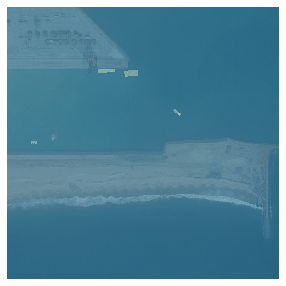

In [13]:
out.show()

<a id='Pipeline'></a>
#### 2. Chaining Transform into a Pipeline

In [14]:
tfms_ls = [RawExtract(csv_path), Rasterize(), Semantize(), Resize(224), ToTensor()]
pipeline = Pipeline(tfms_ls)
pipeline.setup()

In [15]:
pipeline

Pipeline: RawExtract -> Rasterize -> Semantize -> Resize -> ToTensor

In [16]:
enc = pipeline(img_id)
dec = pipeline.decode(enc)
type(enc), type(enc[0]), enc[0].shape, type(dec), type(dec[0])

(__main__.LabeledImage,
 fastai2.torch_core.TensorImage,
 torch.Size([3, 224, 224]),
 __main__.LabeledImage,
 fastai2.torch_core.TensorImage)

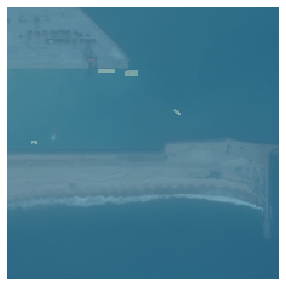

In [17]:
pipeline.show(enc);

<a id='TfmdLists'></a>
#### 3. TfmdLists

In [18]:
splits = RandomSplitter(seed = 42)(items)
tfms_ls = [RawExtract(csv_path), Rasterize(), Semantize(), 
           FlipItem(p = 0.5), Resize(224), ToTensor()]

tls = TfmdLists(items, tfms_ls, splits = splits)
out = tls[0]
out[0].shape, type(out[0]), out[1].shape, type(out[1])

(torch.Size([3, 224, 224]),
 fastai2.torch_core.TensorImage,
 torch.Size([224, 224]),
 fastai2.torch_core.TensorMask)

In [19]:
tls.valid.tfms, tls.train.tfms

(Pipeline: RawExtract -> Rasterize -> Semantize -> FlipItem -> Resize -> ToTensor,
 Pipeline: RawExtract -> Rasterize -> Semantize -> FlipItem -> Resize -> ToTensor)

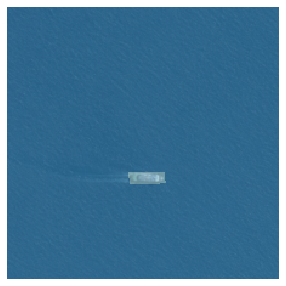

In [20]:
tls[2].show();

<a id='DataLoaders'></a>
#### 4. DataLoaders

In [21]:
batch_tfms = [IntToFloatTensor(), *aug_transforms()]
dls = tls.dataloaders(bs = 64, after_batch = batch_tfms)
#dls = tls.dataloaders(bs = 64)

In [22]:
b = dls.one_batch()
type(b)

__main__.LabeledImage

In [23]:
type(b[0]), b[0].shape, b[1].shape

(fastai2.torch_core.TensorImage,
 torch.Size([64, 3, 224, 224]),
 torch.Size([64, 224, 224]))

In [24]:
b[0][0, :3, :3]

tensor([[[0.3552, 0.3320, 0.3373,  ..., 0.3652, 0.3427, 0.2945],
         [0.3582, 0.3494, 0.3812,  ..., 0.3748, 0.3404, 0.3112],
         [0.3531, 0.3641, 0.3450,  ..., 0.3279, 0.3029, 0.3098]],

        [[0.5160, 0.4928, 0.4981,  ..., 0.5123, 0.4800, 0.4349],
         [0.5190, 0.5087, 0.5401,  ..., 0.5202, 0.4794, 0.4503],
         [0.5139, 0.5240, 0.5050,  ..., 0.4752, 0.4443, 0.4476]],

        [[0.5997, 0.5732, 0.5753,  ..., 0.6036, 0.5615, 0.5104],
         [0.5992, 0.5940, 0.6281,  ..., 0.6215, 0.5705, 0.5330],
         [0.5959, 0.6081, 0.5893,  ..., 0.5716, 0.5333, 0.5279]]])

In [25]:
@typedispatch
def show_batch(x: LabeledImage, y, samples, 
               ctxs = None, max_n = 6, 
               nrows = None, ncols = 2, 
               figsize = None, **kwargs):
    if figsize is None: 
        figsize = (ncols * 6, max_n // ncols * 3)
    if ctxs is None: 
        ctxs = get_grid(
            min(x[0].shape[0], max_n), 
            nrows = None, ncols = ncols, 
            figsize = figsize
        )
    for i,ctx in enumerate(ctxs): 
        LabeledImage(x[0][i], x[1][i]).show(ctx=ctx)

In [26]:
dls._types

{__main__.LabeledImage: [fastai2.torch_core.TensorImage,
  fastai2.torch_core.TensorMask]}

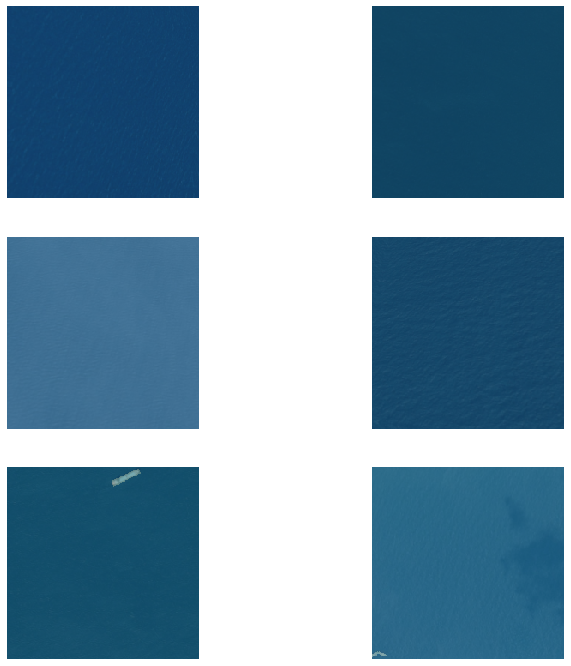

In [29]:
dls.show_batch();

<a id='Datablock'></a>
#### Appendix: Pack by Datablock

In [22]:
PATH.ls()

(#5) [Path('/userhome/34/h3509807/ship-data/test_v2'),Path('/userhome/34/h3509807/ship-data/train_ship_segmentations_v2.csv'),Path('/userhome/34/h3509807/ship-data/airbus-ship-detection.zip'),Path('/userhome/34/h3509807/ship-data/sample_submission_v2.csv'),Path('/userhome/34/h3509807/ship-data/train_v2')]

In [23]:
col = ColReader(cols = 'ImageId', pref = PATH / 'train_v2')
test_df = pd.read_csv(PATH.ls()[1])
test_df.shape

(231723, 2)

In [24]:
test_df.head(3)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971...
